# Clasificación Multimodal (Texto + Imagen) con el Dataset Fakeddit

El presente trabajo aborda la tarea de detección de noticias falsas utilizando un enfoque **multimodal**, es decir, combinando información textual e información visual (imagen). Para ello, se emplea el conjunto de datos **Fakeddit**, un dataset diseñado específicamente para la detección de desinformación en múltiples modalidades. Fakeddit es un recurso de gran utilidad para avanzar en el desarrollo de herramientas capaces de combatir la propagación de noticias falsas tanto en texto como en imagen.

En esta implementación, el objetivo consiste en clasificar las publicaciones en una de **seis categorías predefinidas**:

- Contenido auténtico / verdadero  
- Sátira o parodia  
- Conexión falsa (cuando el título o imagen no corresponde con el contenido real)  
- Contenido impostor (cuando se suplanta una fuente legítima)  
- Contenido manipulado (edición de imágenes o textos para engañar)  
- Contenido engañoso (cuando se presenta información verdadera en un contexto incorrecto o sesgado)

---

## Extracción de características a partir de imágenes

Para el análisis visual, se utiliza un modelo **ResNet50 preentrenado** sobre el conjunto de datos ImageNet, ampliamente reconocido por su eficacia en tareas de clasificación de imágenes. ResNet50 es una red neuronal profunda con **50 capas**, introducida por Microsoft Research en 2015, que destaca por su arquitectura de **conexiones residuales o *skip connections***.

Estas conexiones permiten que el modelo evite el problema del **desvanecimiento del gradiente** durante el proceso de retropropagación, facilitando así un **entrenamiento más estable y eficiente**. Gracias a estas características, ResNet50 logra una mayor precisión en tareas de visión por computadora y una **convergencia más rápida** durante el entrenamiento.

---

## Extracción de características a partir de texto

Para el análisis textual, se emplea el modelo **BERT preentrenado** (*Bidirectional Encoder Representations from Transformers*), concretamente una versión entrenada con el corpus de Wikipedia en inglés y el Toronto Book Corpus en minúsculas (*lowercase*). Este modelo ha sido seleccionado por su capacidad para capturar de manera rica el significado contextual del lenguaje natural.

### ¿Por qué utilizar BERT y sus embeddings?

A diferencia de modelos tradicionales que procesan el texto de forma secuencial, **BERT adopta un enfoque bidireccional**, considerando simultáneamente el contexto de las palabras tanto a la izquierda como a la derecha de una palabra objetivo. Esto permite obtener **representaciones semánticas más completas** y profundas.

De BERT se extraen vectores de características denominados **embeddings de palabras y oraciones**, los cuales se utilizan como entrada de alta calidad para modelos posteriores. Dado que modelos de PLN como LSTM o CNN requieren vectores numéricos como entrada, **BERT se convierte en una opción idónea** para codificar textos de longitud variable en representaciones vectoriales fijas y significativas.




## 1. Carga de librerías

Importamos todas las bibliotecas necesarias para el procesamiento de datos, aprendizaje profundo, visualización, manipulación de imágenes y manejo de modelos preentrenados.


In [1]:
# Import statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import urllib.request # to import images from dataset
import sys

from sklearn.model_selection import train_test_split

In [2]:
# Import Neural Network and PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim

import torchvision
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim.lr_scheduler as lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt

## 2. Montar Google Drive

Conectamos Google Drive para acceder a los archivos almacenados allí, como el dataset `multimodal_train.tsv`.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


## 4. Carga del dataset

Leemos el archivo `multimodal_train.tsv`, que contiene los títulos, etiquetas y rutas a imágenes de las publicaciones. Visualizamos las primeras filas para comprender su estructura.


In [5]:
df = pd.read_csv('/content/drive/MyDrive/TFG/multimodal_train.tsv', sep='\t')
df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [6]:
df.drop(['2_way_label', '3_way_label', 'title'], axis = 1, inplace =True)

## Limpieza del DataFrame

Dado que este proyecto se centra en una **clasificación de 6 clases**, se eliminan las columnas correspondientes a las clasificaciones binarias (2 clases) y ternarias (3 clases), ya que no son necesarias para esta tarea.

El conjunto de datos incluye una columna `clean_title` que contiene los títulos ya preprocesados, es decir, con texto limpio y normalizado. Por ello, se descarta la columna `title` original sin procesar.

Además, el tokenizador utilizado para el procesamiento del texto es **`bert-base-uncased`**, que ha sido entrenado específicamente con texto en minúsculas. Por este motivo, es fundamental utilizar la columna `clean_title`, ya que está en el formato adecuado para ser procesado correctamente por este modelo.


## División del conjunto de datos

El conjunto de datos original de Fakeddit contiene más de **700.000 muestras**, lo que puede resultar muy costoso en términos de tiempo y recursos computacionales.

Para facilitar el desarrollo y las pruebas, se aplica la función `train_test_split()` para reducir el tamaño del dataset. En concreto, se reutiliza únicamente el **10% del total** como conjunto de entrenamiento personalizado.

Además, se utiliza el parámetro `stratify` durante la división para **preservar la distribución de clases original**. Esto asegura que la proporción de muestras por clase en el conjunto reducido se mantenga representativa respecto al dataset completo de Fakeddit.


In [7]:
# Splitting complete Fakeddit-dataset into 10% training dataframe and 90%
# backup dataframe
# This is to work with a smaller sample size of data
df, df_backup = train_test_split(
    df,
    test_size=0.95,
    shuffle=True,
    # To maintain percentage of samples per class as given by original dataset
    stratify=df["6_way_label"]
)

In [8]:
# Reset indexes as we are now working with a smaller sample of original dataset
df.reset_index(drop=True, inplace=True)
df

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,6_way_label
0,tachyonweb,this plants survival strategy is to look like ...,1.510694e+09,i.redd.it,True,7cyua1,https://preview.redd.it/7kt9ysk6b0yz.jpg?width...,NaN,0.0,24,pareidolia,0.90,2
1,Lagath0r,the way these fan blades have warped,1.548022e+09,i.redd.it,True,ai2vxu,https://preview.redd.it/r5s73upchnb21.jpg?widt...,NaN,5.0,10,mildlyinteresting,0.92,0
2,shittyfoodporn_SS,swiss cheddar hot sauce all on a hotpocket you...,1.454940e+09,i.imgur.com,True,44r025,https://external-preview.redd.it/S6tVP92sAhMiH...,NaN,1.0,225,subredditsimulator,0.99,3
3,theskabus,young frankenstien,1.393515e+09,NaN,True,cfq3gr4,http://i.imgur.com/96IbgK2.jpg,1z2s51,NaN,706,psbattle_artwork,NaN,4
4,Mzilikazi81,a philadelphia radio show raised tons of food ...,1.512787e+09,wmmr.com,True,7ik1dr,https://external-preview.redd.it/T0ThZ7DMLkalH...,NaN,20.0,756,upliftingnews,0.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,SubwayKittens,television demonstration in,1.397315e+09,i.imgur.com,True,22uuv3,https://external-preview.redd.it/Jmpqt3aRALAbW...,NaN,2.0,5,photoshopbattles,1.00,0
28196,Subject_Removed,subject removed,1.405986e+09,NaN,True,cj3x3xu,http://i.imgur.com/UOcnmBm.jpg,2bbbbc,NaN,1,psbattle_artwork,NaN,4
28197,vangoghwhere,this bathroom with stalls as dividers for urinals,1.538090e+09,i.redd.it,True,9jhrr4,https://preview.redd.it/e50uh22h6vo11.jpg?widt...,NaN,8.0,13,mildlyinteresting,0.93,0
28198,RenewedWanderer,kayne west my beautiful dark twisted fantasy,1.553567e+09,i.imgur.com,True,b5jzoa,https://external-preview.redd.it/eDDVvsdyA2YqJ...,NaN,0.0,79,fakealbumcovers,0.98,1


In [9]:
print(df['clean_title'].isnull().sum())
print(df['id'].isnull().sum())
print(df['hasImage'].isnull().sum())

# Check for how many rows the column hasImage would be False
print(df['hasImage'].value_counts())

0
0
0
hasImage
True    28200
Name: count, dtype: int64


<Axes: title={'center': '6_way_label'}, ylabel='Frequency'>

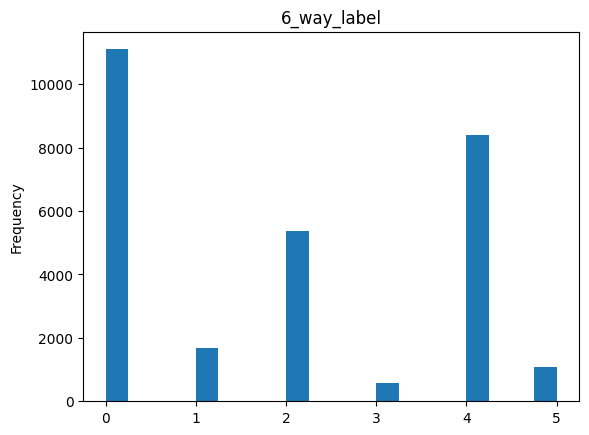

In [10]:
from matplotlib import pyplot as plt
df['6_way_label'].plot(kind='hist', bins=20, title='6_way_label')

## Descarga de imágenes desde URL al directorio de trabajo

Para incorporar las imágenes al proyecto, se realiza la descarga de los archivos desde las URLs proporcionadas en el dataset. Para ello, se utiliza el módulo `request` de la librería `urllib`, que permite manejar las solicitudes y guardar las imágenes localmente.

Antes de iniciar el proceso de descarga, se reemplazan todos los valores `NaN` del DataFrame por cadenas vacías utilizando los métodos `.replace()` y `.fillna()`. 

La función `urlopen()` se emplea para acceder a cada URL de imagen y descargar su contenido, que luego se guarda como un archivo `.jpg` utilizando el `id` de la fila correspondiente como nombre de archivo. Esto permite un acceso sencillo y estructurado a las imágenes en futuras etapas del proceso.

Durante la descarga se detectó que algunas URLs de imagen ya no están disponibles o han sido eliminadas. En estos casos, se eliminan las filas correspondientes del DataFrame para evitar errores o imágenes faltantes en el entrenamiento del modelo.


In [11]:
from urllib import request

# Replace NaN values with empty strings
df = df.replace(np.nan, '', regex=True)
df.fillna('', inplace=True)

# Make a directory to download images into
if not os.path.exists("/content/drive/MyDrive/TFG/images/"):
  os.makedirs("/content/drive/MyDrive/TFG/images/")

for index, row in df.iterrows():
  if row["hasImage"] == True and row["image_url"] != "" and row["image_url"] != "nan":
    image_url = row["image_url"]
    path = "/content/drive/MyDrive/TFG/images/" + row["id"] + ".jpg"

    try:
      f = open(path, 'wb')
      f.write(request.urlopen(image_url).read())
      f.close()

    except:
        # To account for now invalid image urls
        df.drop(index = index, axis = 0, inplace = True)
        pass

print("Downloaded all images.")
df.reset_index(drop=True, inplace=True)

Downloaded all images.


(320, 320, 3)


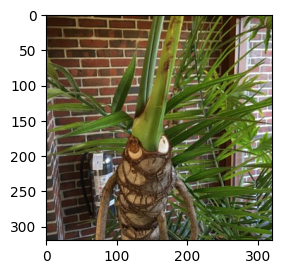

(426, 320, 3)


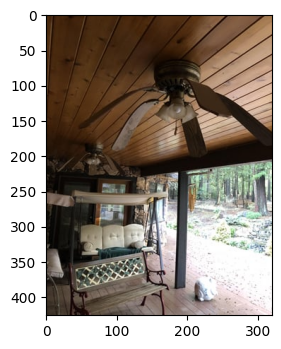

(240, 320, 3)


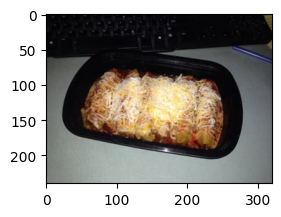

(180, 320, 3)


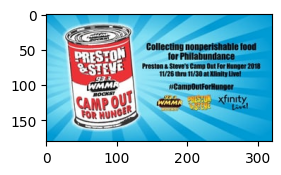

(244, 320, 3)


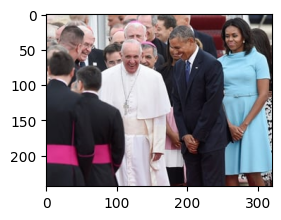

In [12]:
# Plotting images to test download
for i in range(5):
    path = "/content/drive/MyDrive/TFG/images/" + df["id"][i] + ".jpg"

    im= np.array(Image.open(path))

    print(im.shape)
    ax= plt.subplot(121)
    ax.imshow(im)

    plt.show()

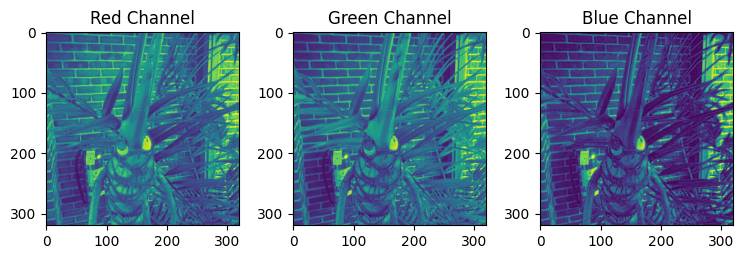

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the RGBA image
image_path = "/content/drive/MyDrive/TFG/images/" + df["id"][0] + ".jpg"
image = Image.open(image_path).convert("RGB")

# Split the image into individual channels
r, g, b = image.split()

# Plot each channel separately
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(r)
plt.title('Red Channel')

plt.subplot(1, 4, 2)
plt.imshow(g)
plt.title('Green Channel')

plt.subplot(1, 4, 3)
plt.imshow(b)
plt.title('Blue Channel')

#plt.subplot(1, 4, 4)
#plt.imshow(a)
#plt.title('Alpha Channel')

plt.tight_layout()
plt.show()

## Verificación de integridad de las imágenes descargadas

Durante el proceso de redimensionamiento de las imágenes, se detectaron errores relacionados con algunos archivos corruptos. Esto se debe, presumiblemente, a imágenes que fueron descargadas desde enlaces que actualmente están caídos o que contenían archivos dañados.

Para garantizar la calidad e integridad del conjunto de datos visual, se recorre el dataset de imágenes comprobando que **todas puedan abrirse correctamente**. En los casos en que una imagen no puede abrirse (por estar incompleta o dañada), se **elimina la fila correspondiente del DataFrame**.

Esta validación es crucial para evitar errores en etapas posteriores del procesamiento y asegurar que el modelo reciba únicamente entradas válidas.


In [14]:
def validate_images(directory):
    corrupted_files = []

    # Walk through directory and sub-directories
    for index, row in df.iterrows():
      image_path = "/content/drive/MyDrive/TFG/images/" + row["id"] + ".jpg"
      try:
          with Image.open(image_path) as img:
              img.verify()
      except Exception as e:
          corrupted_files.append(image_path)
          print(f"Error with {image_path}: {e}")
          df.drop(index = index, axis = 0, inplace = True)

    return corrupted_files

# Example usage:
directory = "/content/drive/MyDrive/TFG/images/"
corrupted_images = validate_images(directory)
if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images.")
else:
    print("All images are valid!")
df.reset_index(drop=True, inplace=True)

Error with /content/drive/MyDrive/TFG/images/bftign.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFG/images/bftign.jpg'
Error with /content/drive/MyDrive/TFG/images/b0f9ha.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFG/images/b0f9ha.jpg'
Error with /content/drive/MyDrive/TFG/images/c2oo2y.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFG/images/c2oo2y.jpg'
Error with /content/drive/MyDrive/TFG/images/d67tu0.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFG/images/d67tu0.jpg'
Error with /content/drive/MyDrive/TFG/images/b93jx5.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFG/images/b93jx5.jpg'
Error with /content/drive/MyDrive/TFG/images/c85ok8.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFG/images/c85ok8.jpg'
Error with /content/drive/MyDrive/TFG/images/b5aa0r.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFG/images/b5aa0r.jpg'
Error with /c

## Redimensionamiento y normalización de imágenes

Todas las imágenes del conjunto de datos se redimensionan a un tamaño estándar de **(256, 256)** utilizando la función `Resize` de `torchvision.transforms`, proporcionada por PyTorch. Las imágenes redimensionadas **sobrescriben los archivos originales** para mantener una estructura de datos uniforme.

Además, cada imagen se convierte explícitamente al formato **RGB**, asegurando así que todas tengan los mismos **tres canales de color**, lo cual es necesario para un procesamiento coherente.

Este preprocesamiento es fundamental para poder pasar las imágenes a través de una **red neuronal convolucional (CNN)**, ya que todas las entradas deben tener el mismo tamaño: una matriz tridimensional de dimensiones **(256, 256, 3)**.


In [15]:

# Resizing all the images to a standard (256,256, 3) using pytorch

# Define the desired size
new_size = (256, 256)

for index, row in df.iterrows():
    image_path = "/content/drive/MyDrive/TFG/images/" + row["id"] + ".jpg"
    image = Image.open(image_path).convert("RGB")

    # Resize the image using PyTorch's torchvision.transforms
    resize_transform = v2.Resize(new_size)
    resized_image = resize_transform(image)
    resized_image.save(image_path)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(256, 256, 3)


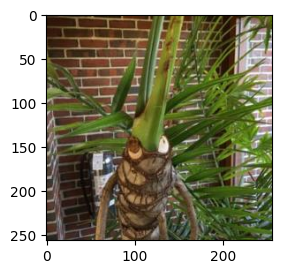

(256, 256, 3)


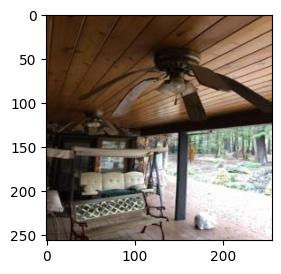

(256, 256, 3)


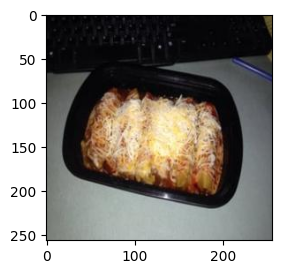

(256, 256, 3)


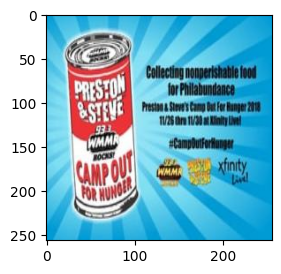

(256, 256, 3)


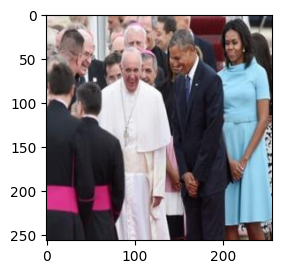

In [16]:
# Plotting images to test resize
for i in range(5):
    path = "/content/drive/MyDrive/TFG/images/" + df["id"][i] + ".jpg"

    im= np.array(Image.open(path))

    print(im.shape)
    ax= plt.subplot(121)
    ax.imshow(im)

    plt.show()

## Generación de embeddings BERT a partir de los títulos

Se utiliza el **tokenizador de BERT** para convertir los títulos normalizados (`clean_title`) —que son cadenas de longitud variable— en vectores numéricos de longitud fija. Este proceso permite transformar el texto en una representación adecuada para modelos de aprendizaje automático.

Mediante un modelo BERT preentrenado de la librería **Transformers de Hugging Face**, se generan **embeddings** para los títulos extraídos de Reddit. Específicamente, se utiliza **BERT base**, que cuenta con una red alimentada hacia adelante (feed-forward) con **768 unidades ocultas**. Como resultado, se obtiene un **vector de longitud fija (768 elementos)** para cada título, independientemente de su longitud original.

Estos vectores se pueden utilizar directamente como entrada en una **red neuronal** para tareas de clasificación.


In [17]:
import torch
from transformers import BertModel, BertTokenizer

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name, output_hidden_states = True)

# Put the model in evaluation mode, which turns off dropout regularization which is used in training.
bert_model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [18]:
def get_bert_embedding(text):
    # Tokenize input text and get token IDs and attention mask
    inputs = tokenizer.encode_plus(text, add_special_tokens = True, return_tensors='pt', max_length=80, truncation=True, padding='max_length')

    return inputs['input_ids'].squeeze(0), inputs['attention_mask'].squeeze(0)

# Testing embedding
text = "This is an example Reddit submission title."
input_ids, attention_mask = get_bert_embedding(text)
print(input_ids.shape)
print(attention_mask.shape)
# print(embedding)

torch.Size([80])
torch.Size([80])


In [19]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["6_way_label"])
df_test, df_val = train_test_split(df_test, test_size=0.5, stratify=df_test["6_way_label"])

## Creación de la clase FakedditDataset

Se define la clase `FakedditDataset`, que hereda de la clase `Dataset` de PyTorch. Esta clase personalizada gestiona el preprocesamiento y la estructura de los datos para facilitar su uso durante el entrenamiento.

Cada muestra del dataset realiza las siguientes operaciones:

- Aplica transformaciones predefinidas a la **imagen**, incluyendo redimensionamiento y conversión a tensor.
- Procesa el texto mediante el **tokenizador de BERT**, generando los tensores `input_ids` y `attention_mask`.
- Devuelve la **etiqueta correspondiente** de entre las 6 clases posibles.

Durante las pruebas, se observó que la aplicación de **normalización sobre las imágenes** afectaba negativamente al rendimiento del modelo (tendía a predecir todas las clases como 0). Por este motivo, se optó por **no incluir la normalización** en la lista de transformaciones aplicadas.

La clase `FakedditDataset` encapsula toda la información necesaria para cada muestra. Un `DataLoader` recorre este dataset y entrega los datos al modelo en **batches de tamaño 16**, lo que permite entrenar de manera eficiente utilizando GPU o CPU.


In [20]:
class FakedditDataset(Dataset):
    def __init__(self, df, text_field="clean_title", label_field="6_way_label", image_id="id"):
        self.df = df.reset_index(drop=True)
        self.text_field = text_field
        self.label_field = label_field
        self.image_id = image_id

        self.img_size = 256
        # Using the pre-calculated ImageNet mean and std values for normalization
        self.mean, self.std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

        self.transform_func = v2.Compose(
                [   v2.Resize(256),
                    v2.ToImage(),
                    v2.ToDtype(torch.float32, scale=True),
                    v2.Normalize(self.mean, self.std)
                    ])

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.df.at[index, self.label_field]
        img_path = "/content/drive/MyDrive/TFG/images/" + self.df.at[index, self.image_id] + ".jpg"

        image = Image.open(img_path)
        img = self.transform_func(image)

        input_ids, attention_mask = get_bert_embedding(text)

        return input_ids, attention_mask, label, img

    def __len__(self):
        return self.df.shape[0]

In [21]:
train_dataset = FakedditDataset(df_train)
test_dataset = FakedditDataset(df_test)
val_dataset = FakedditDataset(df_val)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

print(len(train_loader))

# Verifying dataset was created accurately
input_ids, attention_mask, label, img = next(iter(train_loader))
print(input_ids.shape, attention_mask.shape, label.shape, img.shape)

937
torch.Size([16, 80]) torch.Size([16, 80]) torch.Size([16]) torch.Size([16, 3, 256, 256])


## Construcción de un modelo: BERTResNetClassifier

Se define la clase `BERTResNetClassifier`, un modelo **multimodal** que combina información textual y visual. Esta clase hereda de `nn.Module` (PyTorch) y procesa:

- Los **títulos** de las publicaciones mediante un modelo preentrenado **BERT-base**.
- Las **imágenes** asociadas mediante un modelo **ResNet50** también preentrenado.

Este diseño está basado en la arquitectura ilustrada en `resnet-bert-arch.png`, que sirve como referencia para la integración de ambas modalidades.

---

### ¿Por qué usar ResNet en lugar de una CNN superficial?

Las **Redes Residuales (ResNet)** son una arquitectura de redes neuronales convolucionales (CNN) que introducen **conexiones por atajo** (*skip connections*) para abordar el problema del **desvanecimiento del gradiente** durante el entrenamiento de redes profundas.

Las principales ventajas de utilizar **ResNet50** frente a CNNs más simples son:

- Obtienen **mejor precisión** al entrenar con conjuntos de imágenes pequeños o medianos.
- Presentan una **pérdida (loss) más baja** y una **convergencia más rápida**.
- Su arquitectura con **cuellos de botella** (*bottlenecks*), que incluyen convoluciones 1x1 para reducir y restaurar la dimensionalidad, ofrece una mejor eficiencia de parámetros.

---

### Fusión de características y activación

Para fusionar la información textual y visual, se utiliza la función `torch.max()`, que combina ambas representaciones tomando el valor máximo en cada dimensión del vector resultante.

Como función de activación final se aplica **softmax()**, en conjunto con la función de pérdida **CrossEntropyLoss**, que es adecuada para tareas de clasificación multiclase.


In [23]:
class BERTResNetClassifier(nn.Module):
    def __init__(self, num_classes=6):

        super(BERTResNetClassifier, self).__init__()

        self.num_classes = num_classes

        # Image processing (ResNet)
        self.image_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Image processing (Fully Connected Layer)
        self.fc_image = nn.Linear(in_features=1000, out_features=num_classes, bias=True)

        # Dropout layer
        self.drop = nn.Dropout(p=0.3)

        # Text processing (using the 768-dimensional BERT arrays)
        self.text_model = BertModel.from_pretrained("bert-base-uncased")

        # Text processing (Fully Connected Layer)
        self.fc_text = nn.Linear(in_features=self.text_model.config.hidden_size, out_features=num_classes, bias=True)

        # Fusion and classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image, text_input_ids, text_attention_mask,):
        # Image branch
        x_img = self.image_model(image)
        x_img = self.drop(x_img)
        x_img = self.fc_image(x_img)

        # Text branch
        x_text_last_hidden_states = self.text_model(
            input_ids = text_input_ids,
            attention_mask = text_attention_mask,
            return_dict=False
        )
        x_text_pooled_output = x_text_last_hidden_states[0][:, 0, :]
        x_text = self.drop(x_text_pooled_output)
        x_text = self.fc_text(x_text_pooled_output)

        # Fusion and max merge
        x = torch.max(x_text, x_img)

        # Classification
        #x = self.softmax(x) #-> already applied in crossentropy loss

        return x

In [24]:
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [25]:
labels = df_train['6_way_label'].to_numpy()

In [27]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=5, verbose=True)

  # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for input_ids, attention_mask, label, img in train_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            optimizer.zero_grad()

          # Forward pass
            outputs = model(img, input_ids, attention_mask)
            loss = criterion(outputs, label)

          # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()* img.size(0)

       # Validating model and ensuring loss is decreasing
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        with torch.no_grad():
            for input_ids, attention_mask, label, img in val_loader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                label = label.to(device)
                img = img.to(device)

                outputs = model(img, input_ids, attention_mask)
                loss = criterion(outputs, label)
                val_loss += loss.item() * img.size(0)

                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == label)

        val_loss = val_loss / len(val_loader.dataset)
        accuracy = correct_preds.double() / len(val_loader.dataset)
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader.dataset):.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

In [28]:
from sklearn.metrics import precision_score, recall_score

def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_losses = []
    correct_preds = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, label, img in test_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            outputs = model(
                  image = img,
                  text_input_ids = input_ids,
                  text_attention_mask = attention_mask
            )

            # Final Softmax layer returns class predictions per sample in batch
            # Highest probability value resembles class prediction and is assigned to preds variable
            _, preds = torch.max(outputs, dim=1)
            #print(outputs)

            # Loss is calculated by applying Cross Entropy Loss
            val_loss = criterion(outputs, label)

            # Counting correct model predictions and incrementing correct prediction count
            correct_preds += torch.sum(preds == label)
            print(preds, label)

            # Appending current loss per batch to list of losses per epoch
            val_losses.append(val_loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())


    accuracy = float((correct_preds.double() / len(df_test)) * 100)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print("\nAccuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BERTResNetClassifier(num_classes=6)
model= model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-6, factor=0.5, patience=1, verbose=True)
num_epochs = 20

train_model(model, train_loader,val_loader, criterion, optimizer, scheduler, num_epochs)
#print("\n")
evaluate_model(model, test_loader, criterion)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


Epoch 1/20, Training Loss: 1.2112, Validation Loss: 1.0194, Accuracy: 0.6238
Epoch 2/20, Training Loss: 0.7200, Validation Loss: 0.9322, Accuracy: 0.6942
Epoch 3/20, Training Loss: 0.4351, Validation Loss: 1.1853, Accuracy: 0.7300
EarlyStopping counter: 1 out of 5
Epoch 4/20, Training Loss: 0.2912, Validation Loss: 1.2470, Accuracy: 0.7385
EarlyStopping counter: 2 out of 5
Epoch 5/20, Training Loss: 0.1800, Validation Loss: 1.4893, Accuracy: 0.7487
EarlyStopping counter: 3 out of 5
Epoch 6/20, Training Loss: 0.1359, Validation Loss: 1.5867, Accuracy: 0.7583
EarlyStopping counter: 4 out of 5
Epoch 7/20, Training Loss: 0.1041, Validation Loss: 1.6832, Accuracy: 0.7540
EarlyStopping counter: 5 out of 5
Early stopping triggered. Stopping training.
tensor([2, 0, 1, 1, 5, 5, 0, 0, 4, 0, 0, 0, 0, 0, 2, 1], device='cuda:0') tensor([1, 2, 1, 0, 5, 5, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1], device='cuda:0')
tensor([0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2], device='cuda:0') tensor([0, 0, 0, 2, 0, 0

In [34]:
complete_model_path = '/content/drive/MyDrive/TFG/multimodal.pth'
torch.save(model.state_dict(), complete_model_path)
print(f"Modelo completo guardado en: {complete_model_path}")

Modelo completo guardado en: /content/drive/MyDrive/TFG/multimodal.pth


In [33]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/content/drive/MyDrive/TFG/my_model.pth')

print("Modelo guardado ✓")

Modelo guardado ✓


In [35]:
import os


complete_model_path = '/content/drive/MyDrive/TFG/multimodal.pth'

# Verifica si el archivo existe
if os.path.exists(complete_model_path):
    size_bytes = os.path.getsize(complete_model_path)
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Archivo encontrado. Tamaño: {size_mb:.2f} MB")
else:
    print("❌ Archivo no encontrado. Revisa la ruta o si el guardado falló.")


✅ Archivo encontrado. Tamaño: 515.57 MB


In [37]:
import os

file_path = "/content/drive/MyDrive/TFG/multimodal.pth"
if os.path.exists(file_path):
    print(f"Tamaño: {os.path.getsize(file_path) / 1024**2:.2f} MB")


Tamaño: 515.57 MB


In [38]:
df.to_csv('/content/drive/MyDrive/TFG/mi_dataframe.csv', index=False)

In [39]:
comentario = df[df['id'] == "1a01cl"]

In [40]:
print(comentario)

         author           clean_title   created_utc       domain  hasImage  \
13040  neffhead  the dark night rises  1.362879e+09  i.imgur.com      True   

           id                                          image_url  \
13040  1a01cl  https://external-preview.redd.it/Bq5cYJENJ4Elt...   

      linked_submission_id num_comments  score         subreddit upvote_ratio  \
13040                               0.0      9  photoshopbattles         0.62   

       6_way_label  
13040            0  


## Fusión Temprana vs Fusión Tardía

Al diseñar modelos multimodales, uno de los aspectos clave es cómo **fusionar la información proveniente de distintas modalidades** (en este caso, texto e imagen). Existen dos enfoques principales: **fusión temprana (early fusion)** y **fusión tardía (late fusion)**.

---

### 🔹 Fusión Temprana (Early Fusion)

La **fusión temprana** consiste en combinar directamente los datos en bruto de cada modalidad antes de aplicar cualquier tipo de procesamiento de alto nivel o predicción. Es decir, los datos de texto e imagen se integran desde el principio, permitiendo al modelo aprender **interacciones conjuntas a nivel de entrada**.

**Ventajas:**

- Permite capturar interacciones entre las modalidades desde el nivel más bajo.
- Requiere **una sola fase de aprendizaje**, ya que no se necesita un procesamiento separado para cada modalidad.

**Desventajas:**

- Los datos en bruto pueden carecer de **información semántica rica**, lo que dificulta la comprensión profunda del contenido.
- Puede limitar la capacidad del modelo para aprender **relaciones complejas entre modalidades**.

---

### 🔹 Fusión Tardía (Late Fusion)

En la **fusión tardía**, cada modalidad se procesa por separado con su propio modelo. Una vez obtenidas las predicciones o representaciones de alto nivel, estas se **combinan posteriormente** para generar la predicción final.

**Ventajas:**

- Es un enfoque **simple y modular**: cada modalidad se entrena de forma independiente.
- Cada modelo puede **extraer información rica y específica** de su tipo de dato (por ejemplo, texto o imagen).
- Es más fácil de depurar y ajustar por separado.

**Desventajas:**

- El sistema no aprende **interacciones cruzadas** entre las modalidades durante el entrenamiento.
- No se aprovecha directamente la **información complementaria** entre texto e imagen.
- Tiene un **mayor coste computacional**, ya que se deben procesar las modalidades por separado.

---

### Enfoque adoptado

En este trabajo se opta por la **fusión tardía**, ya que en experimentos previos se ha demostrado que suele ofrecer **mejores resultados en modelos combinados de imagen y texto**, permitiendo aprovechar al máximo el poder de representación de modelos como BERT y ResNet por separado antes de fusionar sus salidas.
